In [1]:
import h3ppy
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from array import array
import sys
import pandas as pd


import os
os.environ['PYSYN_CDBS']
import pysynphot as S
from astropy.io import ascii

import io
from pathlib import Path
import math

C:\Users\rober\anaconda3\lib\site-packages\pysynphot\locations.py:345: UserWarning: Extinction files not found in C:\Users\rober\Documents\Python Scripts\extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
C:\Users\rober\anaconda3\lib\site-packages\pysynphot\refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for C:\Users\rober\Documents\Python Scripts\mtab\*_tmg.fits
  warnings.warn('No graph or component tables found; '
C:\Users\rober\anaconda3\lib\site-packages\pysynphot\refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for C:\Users\rober\Documents\Python Scripts\mtab\*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
#read in calibrator file
cal = pd.read_csv(r"C:\Users\rober\star 4th order.dat", delim_whitespace=True, skiprows=2)

#making single variables for wavelength in angstroms and microns
cal_ang = cal['lambda']*10000
cal_micron = cal["lambda"]

#read in target file
tar = pd.read_csv(r"C:\Users\rober\jupiter west 4th order.dat", delim_whitespace=True, skiprows=2)

#wavelength for target in angstroms since something later calls for it
#should be identical to cal_ang
tar_ang = tar['lambda']*10000

In [3]:
cnorm_file = pd.read_csv(r"C:\Users\rober\star 4th order.dat", delim_whitespace=True, skipfooter=2049,engine='python')

cnorm = cnorm_file["Normalization"][0]

#dividing calibrator by t_int to get it in units of counts/sec
cal_norm = cal['flux']*cnorm/8.851681

In [4]:
#tnorm_file = pd.read_csv(r"C:\Users\rober\jupiter file.dat", delim_whitespace=True, 
 #                        skipfooter=2048,engine='python')
#tnorm_file

#file was a little janky so I just pulled the normalization directly from the file 
    #(1.46080e+01, or 2.49775e+03) rather than try and figure it out

#dividing calibrator by t_int to get it in units of counts/sec
#4th order
#tar_norm = tar['flux']*2.77151e+01/1.47528

#1st order
#tar_norm = tar['flux']*2.44149e+03/1.47528

#3rd order
#tar_norm = tar['flux']*1.30859e+02/1.47528



tar_norm = tar['flux']*  3.41481e+02/8.851681

In [5]:
tar_norm

0       1794.321258
1        179.886190
2        118.742608
3         76.934368
4        126.312788
           ...     
2043     -67.553718
2044      30.737291
2045      -3.166486
2046      -8.295371
2047       0.000000
Name: flux, Length: 2048, dtype: float64

In [25]:
#load in star spectrum
# A0V       9520     +4.14       kp00_9500[g40] 
#need T_eff = 9520, metallicity = 0, log(g) = 4.14
sp = S.Icat('k93models', 9520, 0, 4.14)

#configure star spectrum into something the bandpass can normalize
Kurucz = S.ArraySpectrum(sp.wave, sp.flux)

In [26]:
#4th order
#flam = 1.026e-13 W/m^2/micron * 10^-1 for the conversion of um, m^2, and W, to AA, cm^2, erg/s
#pulled from Gemini conversion site + simbad data on HD219833
constant = 1.026*10**(-13)*10**(-1)

In [27]:
#find index of center of band (3.43 micron -> 34300 Angstroms)
number = 973
Kurucz.wave[number]

34300.0

In [28]:
starnorm = constant/Kurucz.flux[number]
starnorm

8.710305209530658e-20

In [29]:
Kurucz_band = starnorm*Kurucz.flux

In [30]:
#in units of erg/s/cm^2/AA, should be W/m^2/nm
Kurucz_W = (Kurucz_band)*10**(-2)

In [31]:
#interpolate Kurucz spectrum to calibrator wavelengths so they are the same size & at same wavelengths
interpol = np.interp(cal_ang, Kurucz.wave, Kurucz_W)

In [32]:
#interpolate target spectrum to calibrator wavelengths so they are the same size & at same wavelengths
tar_interpol_flux = np.interp(cal_ang, tar_ang, tar_norm)

In [33]:
#divide target flux by calibrator flux to remove units of cnts/sec and some atmospheric interference
div_flux = tar_interpol_flux / cal_norm

In [34]:
#multiply interpolated Kurucz flux by divided target/cal flux to apply units (and some magnitude)
W_flux = div_flux*interpol

Text(0, 0.5, 'W/m^2/nm')

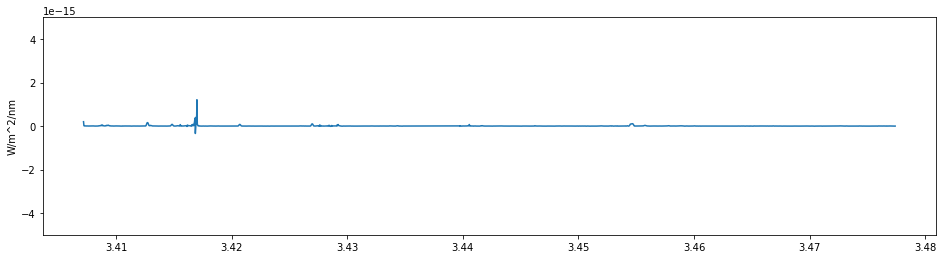

In [35]:
fig, ax = plt.subplots(figsize=[16, 4])



plt.plot(cal['lambda'], W_flux)
plt.ylim(-0.5e-14,0.5e-14)

plt.ylabel('W/m^2/nm')

In [36]:
#nm to micron, multiply by 0.001, 

#set dataset to be used within h3ppy
# Need to convert the instrument FOV to units of sterradian
# The pixel width is 0.144 arcsec with a slit width of 0.288 arcsec (NIRSPEC High resolution echelle)
# Note - there are 4.2545e10 arceconds in a sterradian

spec = W_flux * 0.01 * 4.2545e10 / (0.144 * 0.288)
wavelength = cal['lambda']

In [37]:
wavelength

0       3.407174
1       3.407208
2       3.407243
3       3.407277
4       3.407311
          ...   
2043    3.477269
2044    3.477304
2045    3.477338
2046    3.477372
2047    3.477406
Name: lambda, Length: 2048, dtype: float64

Text(0, 0.5, 'W/m^2/um/sr')

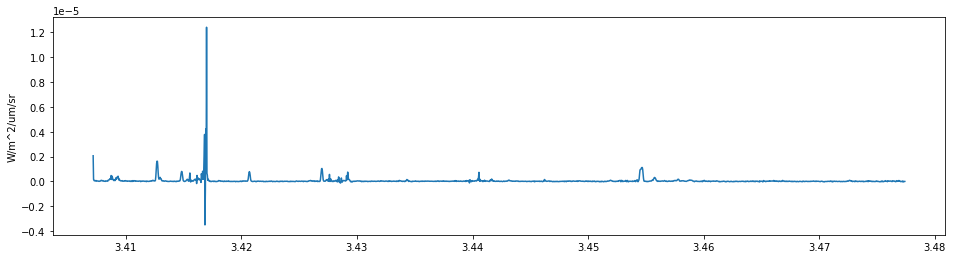

In [38]:
fig, ax = plt.subplots(figsize=[16, 4])



plt.plot(wavelength, spec)
#plt.ylim(-1e-5,1e-5)





#4th order
#plt.axvline(x = 3.42062, color='g')
#plt.axvline(x = 3.42687, color='r')
#plt.axvline(x = 3.45473, color='purple')

#plt.xlim(3.4190, 3.422)
#plt.xlim(3.420, 3.430)
#plt.xlim(3.450, 3.462)





#1st order H3+ locations
#3.97092 (425-475), 3.98538 (1325-1355), 3.98688 (1425-1455)
#3.95285 (1175-1225)
#3.9038 (10-40),3.9285 (1540-1570)

#plt.axvline(x = 3.98688, color='y')
#plt.axvline(x = 3.98538, color='orange')
#plt.axvline(x = 3.97092, color='r')
#plt.axvline(x = 3.95285, color='purple')
#plt.axvline(x = 3.9285, color='g')


plt.ylabel('W/m^2/um/sr')

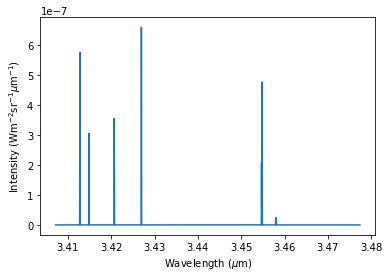

In [39]:
# Create the H3+ object
h3p = h3ppy.h3p()

# Define a wavelength range, e.g. typical of an observation of the H3+ Q branch
# Specify the start and end wavelengths, and the number of wavelength elements
wave = h3p.wavegen(wavelength[0], wavelength[2047], 10000)
#wave = h3p.wavegen(3.934, 4.01667, 10000)

# Create a H3+ model spectrum for a set of physical parameters 
# Spectral resolution R = 1200, T = 1000, N = 1e14
# This is the minimum set of parameters required for generating a model
model = h3p.model(density = 4e+15, temperature = 265, R = 75000, wavelength = wave)

# Plot the model
fig, ax = plt.subplots()
ax.plot(wave, model)

# Automagically set the labels 
ax.set_xlabel(h3p.xlabel())
ax.set_ylabel(h3p.ylabel())
#plt.xlim(3.4530,3.4560)
#plt.ylim(-1e-5,1.5e-4)
plt.show()
#plt.savefig('example_model.png')
#plt.close() 

In [40]:
print(wave[0])

print(wavelength[2047])

3.4071739
3.4774065


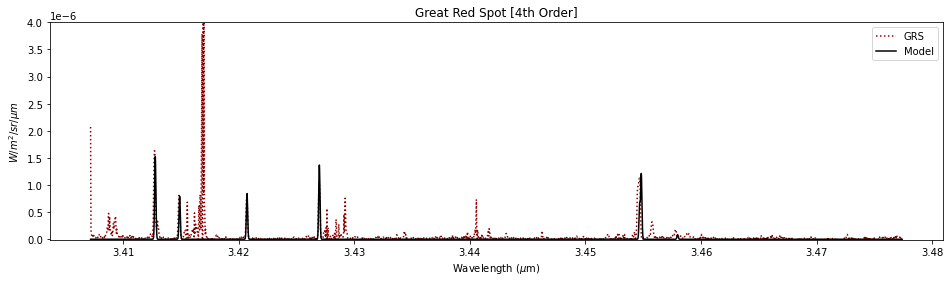

In [82]:
fig, ax = plt.subplots(figsize=[16, 4])


plt.plot(wavelength, spec, label="GRS", color='darkred', linestyle = 'dotted')


#4th order stuff
#published lines
#plt.axvline(x=3.412775, color='lightblue', label='3.4206') 
#plt.axvline(x=3.41488, color='yellow', label='3.42685')
#plt.axvline(x=3.42071, color='salmon', label='3.4206') 
#plt.axvline(x=3.42697, color='pink', label='3.42685')
#plt.axvline(x=3.454685, color='lightgreen', label='3.4547') #doublet, not recognized in h3ppy?
#plt.axvline(x=3.454825, color='lightgreen', label='3.4547')
#plt.axvline(x=3.4566, color='lightblue', label='3.4566') #not published, test?
#plt.axvline(x=3.46755, color='orange', label='3.46755') #not published, test?


#plt.xlim(3.4120, 3.416)
#plt.xlim(3.42, 3.426)
#plt.xlim(3.422, 3.430)
#plt.xlim(3.454, 3.458)




#1st order
#plt.axvline(x=3.95299, color='orange')
#plt.axvline(x=3.971062, color='salmon') 
#plt.axvline(x=3.987017, color='lightgreen')
#plt.axvline(x=3.987018, color='lightgreen')
#plt.axvline(x=3.99463, color='pink')
#plt.axvline(x=4.01197, color='lightblue')
#plt.axvline(x=4.01325, color='lightblue') 

#plt.xlim(3.95, 3.955)
#plt.xlim(3.969, 3.973)
#plt.xlim(3.986, 3.989)
#plt.xlim(3.986, 3.99)
#plt.xlim(3.994, 3.996)
#plt.xlim(4.01, 4.014)


plt.xlabel("Wavelength (" + r'$\mu$' + "m)")
plt.ylabel(r'$W / m^2 /sr / \mu m$')
plt.title("Great Red Spot [4th Order]")
plt.grid(visible=0)
plt.ylim(-1e-8,4e-6)
#plt.xlim(wavelength[0], wavelength[2047])


model = h3p.model(density = 8e+14, temperature =340, R = 25000, wavelength = wave)
ax.plot(wave, model, color = "black", linewidth=1.5, label='Model')


plt.legend(loc="best")
plt.show()

In [23]:
def subdivide(waves, spec, middles, width = 10) : 
    ret = []
    for m in middles :
            centre = np.abs(waves - m).argmin()
            for i in range(centre - width, centre + width) : 
                    ret.append(spec[i])
    return np.array(ret)

In [32]:
width = [5,5]


def subdivide(waves, spec, middles, width = width) : 
    ret = []
    count = 0
    for m in middles :
            centre = np.abs(waves - m).argmin()
            for i in range(10):
                ret.append(0)
            for i in range(centre - width[count], centre + width[count]) : 
                    ret.append(spec[i])
            for i in range(10):
                ret.append(0)
            count = count + 1
    return np.array(ret)

def subdividewave(waves, spec, middles, width = width) : 
    count = 0
    ret = []
    for m in middles : 
            centre = np.abs(waves - m).argmin()
            for i in range(centre - width[count]-10, centre + width[count] + 10) : 
                    ret.append(spec[i])
            count = count + 1
    return np.array(ret)

In [33]:
# The H3+ line centers contained withing this spectral band

#4th order lines
#lines chosen based on clarity?
#centers = [3.42082,3.42698]

#all possible h3+ lines
#centers = [3.42082,3.42698,3.45474,3.4566,3.46755]

#centers = [3.412775,3.41488,3.42697]

#centers = [3.412775,3.41488,3.42071,3.42697,3.454685]



#3rd order lines
centers = [3.61592,3.62046]

#all possible lines
#centers = [3.61592,3.62046,3.63038]

# Create sub-arrays, focusing on where the H3+ lines are
#subspecoff = subdivideoffset(wave, spec, centers)
subspec = subdivide(wavelength, spec, centers)
subwave = subdividewave(wavelength, wave, centers)

In [34]:
subspec = subdivide(wavelength, spec, centers)
subwave = subdivide(wavelength, wave, centers)

In [35]:
print(subspec.shape)
print(subwave.shape)

(60,)
(60,)


In [36]:
h3p = h3ppy.h3p()

# Set the wavelength and the data
h3p.set(wavelength = subwave, data = subspec, R = 20000)

# We need to guess a temperature
h3p.set(temperature = 900)

# We need to guess a density?
#h3p.set(density = 4.0E14)

# Let h3ppy try and guess a wavelength offset
guess = h3p.guess_offset()
# Guess the density and proceed with a five parameter fit
h3p.guess_density()
# Let h3ppy do the fitting - this will do a full five parameter fit
fit = h3p.fit(verbose = True)

[h3ppy] The model generated only zeros - cannot make a guess at any parameter
[h3ppy] The model generated only zeros - cannot make a guess at any parameter
[h3ppy] Number of fitting iterations is set to 14
[h3ppy] Fit failed to converge - solution is numerially unstable 
[h3ppy] In this instance: |ABC| or |Z| are zero.


In [953]:
vars, errs = h3p.get_results()

[h3ppy]  Spectrum parameters:
         Temperature    = 734.2 +/- 0.3 [K]
         Column density = 2.48E+19 +/-  1.27E+21 [m-2]
         ------------------------------
         background_0 = 1.92E-08 +/- 9.61E-05
         offset_0 = -1.47E-03 +/- 4.79E-08
         sigma_0 = 2.67E-04 +/- 2.85E-08



In [37]:
data = 1

if data == 1:
    # Create a x scale for plotting 
    xx      = list(range(len(subspec)))
    xaxis = []
    for i in range(len(xx)):
        xaxis.append(xx[i])
    subspectest = []
    for i in range(len(subspec)):
        subspectest.append(subspec[i])
        
if data == 0:
    # Create a x scale for plotting 
    xx      = list(range(len(subspecoff)))
    xaxis = []
    for i in range(len(xx)):
        xaxis.append(xx[i])
    subspectest = []
    for i in range(len(subspecoff)):
        subspectest.append(subspecoff[i])

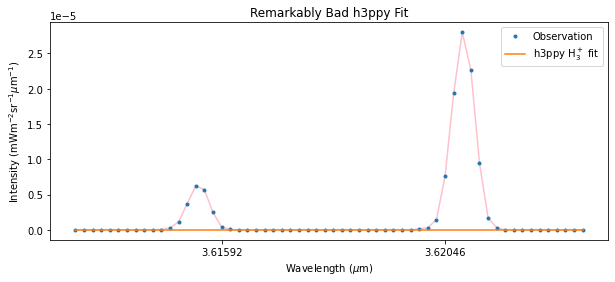

In [38]:
cpos = np.arange(2) * 26 + 17


fig, ax = plt.subplots(figsize=[10, 4])

ax.plot(xaxis, subspectest, 'pink')
ax.plot(xaxis, subspectest, '.', label='Observation')
ax.plot(xx, fit, label = 'h3ppy H$_3^+$ fit')

    
ax.set_title('Remarkably Bad h3ppy Fit')
ax.set(xlabel = h3p.xlabel(), ylabel = h3p.ylabel(prefix = 'm'), xticks = cpos)
ax.set_xticklabels(centers)
ax.legend(frameon = True)
#plt.ylim(-1e-8,8e-7)
#plt.tight_layout()
#plt.savefig('../img/nirspec_jupiter_fit.png')
#plt.close()